#### 导入相关包

In [1]:
%reset -f
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.utils import data
from getdataset import MyDataset,get_images_and_labels
from skimage import io
image_path = r"./data/Inputs_mnist_train_64"
label_path = r"./data/Labels_mnist_train"
data = get_images_and_labels(image_path,label_path)
data_nor = MyDataset(image_path,label_path)


#### 选取一张图

In [45]:
net = torch.load("./net/net_10000.pth")
j = 5000 #np.random.randint(1,9000)
# X1,Y1,m,s = data_nor[i]
X,Y = torch.Tensor(data[0][j-1]),torch.Tensor(data[1][j-1])
mean,sigma = torch.mean(X),torch.sqrt(torch.sum(torch.square(X - torch.mean(X)))/64)
# X,Y = (X-mean)/sigma,Y

#### 使用网络重构

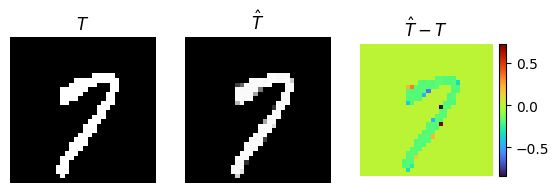

In [46]:
# 用来测试的
x,y = (X.unsqueeze(0)-mean)/sigma,Y.unsqueeze(0)
net.eval()
net.to('cpu')
y_hat = net(x)
fig,axs = plt.subplots(1,3,subplot_kw={'xticks': [], 'yticks': []})

ax0 = axs[0].imshow(y[0,0,:,:].detach().numpy(),'gray');axs[0].set_title("$T$");axs[0].set_axis_off()
ax1 = axs[1].imshow(y_hat[0,0,:,:].detach().numpy(),'gray');axs[1].set_title("$\hat{T}$");axs[1].axis('off')
ax2 = axs[2].imshow(((y_hat-y)/255)[0,0,:,:].detach().numpy(),'turbo');axs[2].set_title("$\hat{T}-T$");axs[2].axis('off')
fig.colorbar(ax2,ax=axs[2],fraction=0.045)

In [47]:
# 重构图像
def recon_image(net,X):
    shape = X.shape
    X_re = X.flatten()
    X_new = torch.Tensor(np.random.choice(X_re,size=64).reshape(shape))
    mean_new,sigma_new = torch.mean(X_new),torch.sqrt(torch.sum(torch.square(X_new - torch.mean(X_new)))/64)
    x_new = (X_new-mean_new)/sigma_new
    net.eval()
    net.to('cpu')
    y_new_hat = net(x_new)
    return y_new_hat

def recon_image_mask(net,X):
    shape = X.shape
    mask = torch.Tensor(np.random.randint(2,size=(8,8)))
    # mask = torch.Tensor(np.ones((8,8)))
    # mask[0,0]=1
    X_new = torch.Tensor(X*mask.unsqueeze(0))
    mean_new,sigma_new = torch.mean(X_new),torch.sqrt(torch.sum(torch.square(X_new - torch.mean(X_new)))/64)
    x_new = (X_new-mean_new)/sigma_new
    net.eval()
    net.to('cpu')
    y_new_hat = net(x_new)
    return y_new_hat


(-0.5, 31.5, 31.5, -0.5)

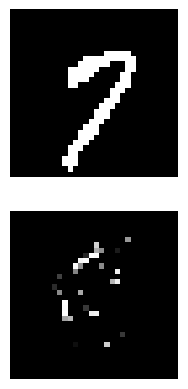

In [48]:

y = Y.unsqueeze(0)
y_new_hat = recon_image_mask(net,X)
ax = plt.subplot(211)
ax.imshow(y[0,0,:,:].numpy(),'gray');ax.axis('off')
ax = plt.subplot(212)
ax.imshow(y_new_hat[0,0,:,:].detach().numpy(),'gray');ax.axis('off')

In [51]:
## 存储生成的数据
# y = torch.zeros((1000,1,32,32))
y = [] 
for i in range(1000):
    temp = recon_image_mask(net,X)[0,0].detach().numpy()
    y.append(temp)
    # y[i,:,:,:] = recon_image_mask(net,X)
yy = np.array(y)/255



#### 计算标准误差

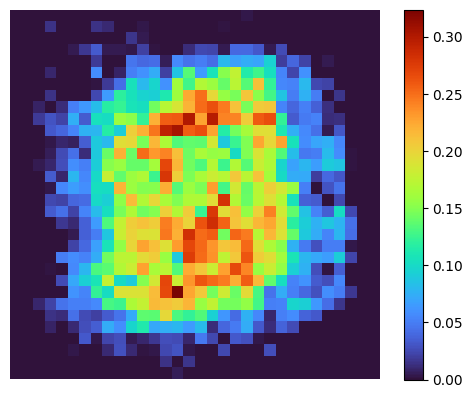

In [52]:

yy_std = np.std(yy,axis=0)
plt.figure();plt.axis('off')
plt.imshow(yy_std,cmap='turbo') # 显示的图和矩阵一致，使用pcolor图像会倒置
plt.colorbar()
plt.savefig('./image/se/'+str(j)+'_se.jpg')
# plt.savefig('./image/'+str(j)+'_se.eps')

#### 计算偏差

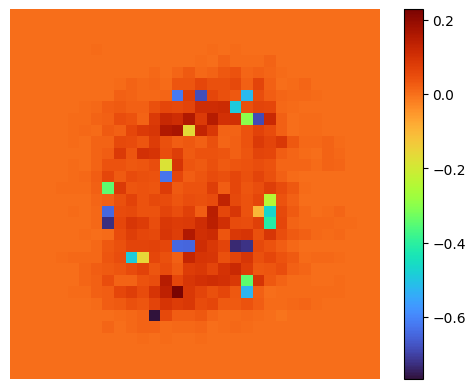

In [26]:
y_b = yy-y_new_hat.squeeze(0).squeeze(1).detach().numpy()/255
y_b_mean = np.mean(y_b,axis=0)
plt.figure();plt.axis('off')
plt.imshow(y_b_mean,cmap='turbo')
plt.colorbar()
# plt.savefig('./image/'+str(j)+'_bias.eps')

#### 计算均方根误差

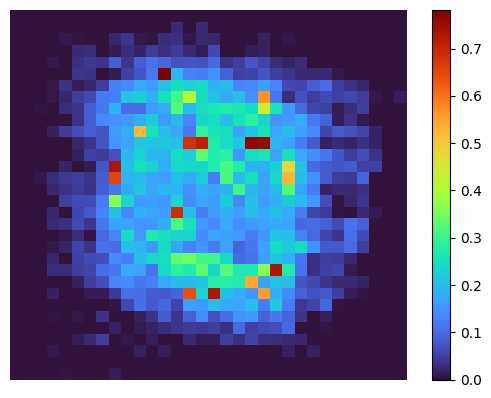

In [28]:

y_r = yy-y_new_hat.squeeze(0).squeeze(1).detach().numpy()/255
y_r_mean = np.sqrt(np.mean(np.square(y_r),axis=0))
plt.figure();plt.axis('off')
plt.pcolor(y_r_mean,cmap='turbo')
plt.colorbar()
# plt.savefig('./image/'+str(j)+'_rmse.eps')